### 发帖量和上证指数的相关性

验证发帖量和回帖量之间是否有关，验证发帖/回帖量是否和上证指数相关


#### 发帖与回帖

发帖和回帖强相关简直是一定的，不过还是用统计方法验证一下

取出所有的主题贴和回复

In [1]:
from model import Posts, Replies
from peewee import *

In [2]:
p = (Posts.select(fn.Count(Posts.id).alias('pcount'), fn.strftime('%Y%m%d', Posts.updated_at).alias('date'))
     .where(SQL('date').is_null(False))
     .group_by(SQL('date'))
     .order_by(SQL('date')))
r = (Replies.select(fn.Count(Replies.id).alias('rcount'), fn.strftime('%Y%m%d', Replies.updated_at).alias('date'))
     .group_by(SQL('date'))
     .order_by(SQL('date')))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

pdf = pd.DataFrame(list(p.dicts()))
rdf = pd.DataFrame(list(r.dicts()))

按照天数统计发帖回帖数量

In [4]:
df = pd.merge(pdf, rdf, on='date')
df.date = pd.to_datetime(df.date)

df.tail()

,date,pcount,rcount
1973,2017-12-27,152,1649
1974,2017-12-28,147,1663
1975,2017-12-29,145,1680
1976,2017-12-30,91,1212
1977,2017-12-31,72,942


在做相关性分析之前先做一下正态性检验

In [5]:
from scipy import stats

normp = stats.kstest(df['pcount'], 'norm')
normr = stats.kstest(df['rcount'], 'norm')
normp, normr

(KstestResult(statistic=0.94792732002350932, pvalue=0.0),
 KstestResult(statistic=0.99410005141225266, pvalue=0.0))

完全不是正态分布啊，那么画图看一下长啥样

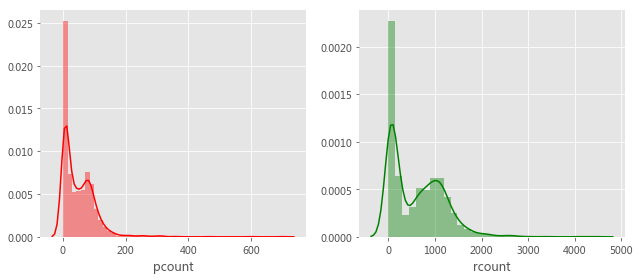

In [6]:

f, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=False)
sns.despine(left=True)

sns.distplot(df['pcount'], color="r", ax=axes[0])
sns.distplot(df['rcount'], color="g", ax=axes[1])

plt.tight_layout()

既然不是正态分布，就不能采用`皮尔森系数`，这里选用`spearman系数`（我也不知道为啥要用这个，我们民科就是这样的啦）`pandas`直接提供了计算相关系数矩阵的方法

In [7]:
df.corr('spearman')

,pcount,rcount
pcount,1.000000,0.973157
rcount,0.973157,1.000000


不过`pandas`似乎没有提供显著性检验的计算方法，所以这里用scipy再算一遍

In [8]:
r, p = stats.spearmanr(df['pcount'], df['rcount'])
r, p

(0.97315673412260795, 0.0)

> spearman系数0.97，P值为0，这结果漂亮的不可能是实力派

相关性用散点图可以直观的展示

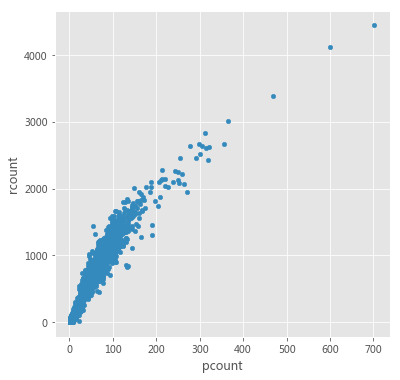

In [9]:
df.plot.scatter(x='pcount', y='rcount', figsize=(6,6))
plt.show()

这里用`seaborn`和`matplotlib` 做个对比，`seaborn`比较强悍的一点就是连回归线都做出来了，还顺便画出了两个变量的分布情况。而同样地图形在plt里的代码量不敢想象

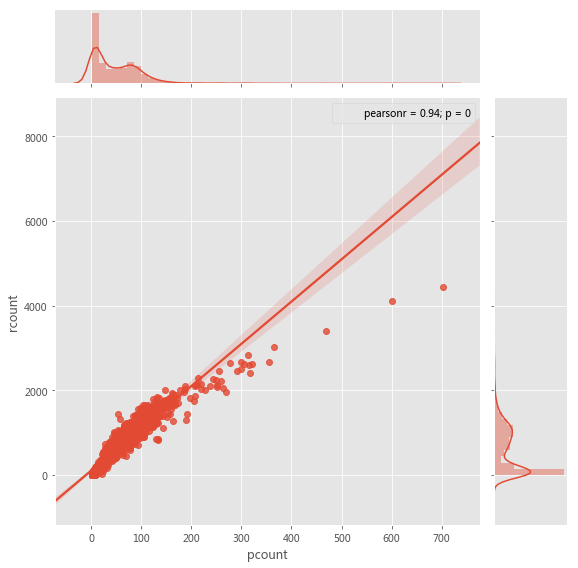

In [10]:
sns.jointplot('pcount', 'rcount', data=df, kind="reg", size=8)
plt.show()

为了图形好看，这里按周统计一下发帖数量。
再引入一个回帖/发帖的比率`ratio`（作为民科，对比率有种莫名的执着），画出历史数据的折线图

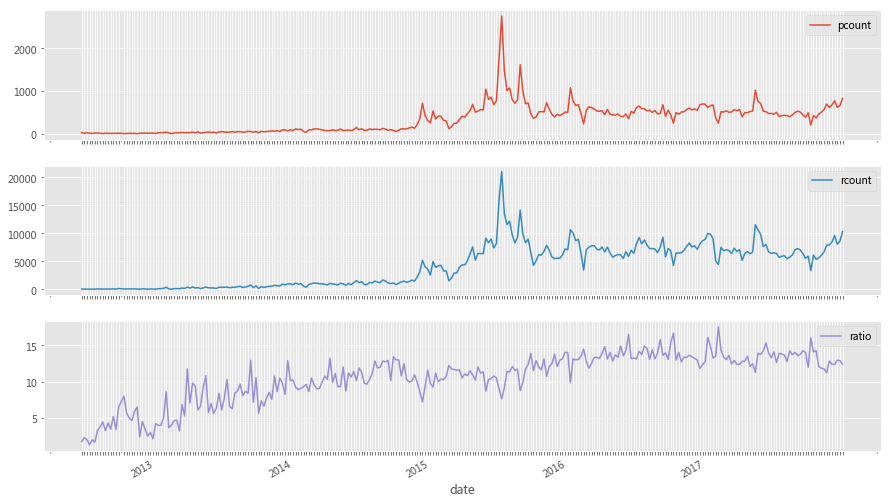

In [11]:
dfg = df.groupby(df.date.dt.to_period('W')).sum()
dfg['ratio'] = dfg.rcount / dfg.pcount

dfg.plot(xticks=dfg.index, subplots=True, figsize=(15,9))
plt.show()

> 很明显发帖回帖图象非常相似，显然相关度是很高的。不过这个比率并不固定，从图象上来看，似乎<del>发帖量到达阶段高峰时，比率会有一个谷值，发帖量到达低谷时，比率会有一个峰值</del>

#### 指数与发帖

利用`tushare`获得上证指数的历史记录，包括了开盘，收盘，最高，最低，成交量，均价，涨跌幅等

In [12]:
import tushare as ts

adf = ts.get_hist_data('sh', ktype='W')
adf.index = pd.to_datetime(adf.index).to_period('W')
adf.head(12)

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2018-02-12/2018-02-18,3128.37,3219.22,3199.16,3113.61,0.0,69.31,2.21,3367.416,3352.814,3360.591,0.0,0.0,2248586.50
2018-02-05/2018-02-11,3411.67,3487.72,3129.85,3062.74,0.0,-332.23,-9.60,3413.372,3361.897,3368.259,0.0,0.0,2723750.85
2018-01-29/2018-02-04,3563.64,3587.03,3462.08,3388.86,0.0,-96.05,-2.70,3465.752,3380.674,3379.447,0.0,0.0,3287523.00
2018-01-22/2018-01-28,3476.99,3574.90,3558.13,3475.67,0.0,70.27,2.02,3434.770,3369.848,3374.606,0.0,0.0,3853820.75
2018-01-15/2018-01-21,3428.95,3498.43,3487.86,3401.96,0.0,58.92,1.72,3382.556,3352.326,3365.055,0.0,0.0,4474194.10
2018-01-08/2018-01-14,3391.55,3435.42,3428.94,3384.56,0.0,37.19,1.10,3338.212,3346.807,3357.238,0.0,530644.7,4935094.65
2018-01-01/2018-01-07,3314.03,3402.07,3391.75,3314.03,0.0,84.58,2.56,3310.422,3341.087,3349.227,0.0,1412637.3,5407215.60
2017-12-25/2017-12-31,3296.21,3312.30,3307.17,3263.73,0.0,10.11,0.31,3295.596,3343.593,3340.066,0.0,2160538.1,6018446.80
2017-12-18/2017-12-24,3268.03,3309.22,3297.06,3254.18,0.0,30.92,0.95,3304.926,3350.741,3337.812,0.0,2903128.6,6648020.80


合并两表再算相关性矩阵

In [13]:
ndf = pd.merge(adf, dfg, left_index=True, right_index=True)
ndf.tail()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,pcount,rcount,ratio
date,,,,,,,,,,,,,,,,
2012-07-16/2012-07-22,2187.887,2197.790,2168.638,2138.792,3329094.75,-17.257,-0.79,2212.884,2270.423,2323.832,2986436.40,3446727.50,3896096.48,13,26,2.000000
2012-07-09/2012-07-15,2210.714,2216.697,2185.895,2152.675,3324005.50,-37.684,-1.70,2240.526,2293.057,2338.435,3006448.65,3581968.33,4004783.69,23,30,1.304348
2012-07-02/2012-07-08,2234.320,2244.832,2223.579,2185.522,3146987.25,-1.852,-0.08,2259.637,2319.669,2351.121,3027540.75,3582027.15,4061328.31,26,53,2.038462
2012-06-25/2012-07-01,2253.514,2253.514,2225.431,2188.716,2793829.50,-35.446,-1.57,2289.608,2336.943,2357.802,3311826.90,3861689.13,4116594.48,22,50,2.272727
2012-06-18/2012-06-24,2313.530,2325.052,2260.877,2253.789,2338265.00,-45.973,-1.99,2311.233,2355.086,2364.129,3531186.50,4070724.33,4189257.93,32,56,1.750000


计算相关性之前，需要先检验数据是否服从正态分布，为了方便，直接做图查看

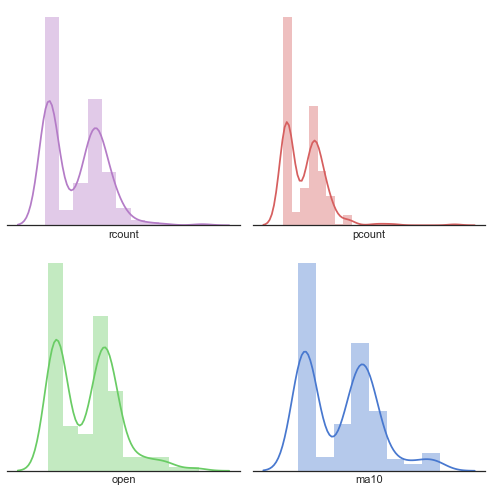

In [14]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=False)
sns.despine(left=True)

sns.distplot(ndf['rcount'], color="m", ax=axes[0, 0])
sns.distplot(ndf['pcount'], color="r", ax=axes[0, 1])
sns.distplot(ndf['open'], color="g", ax=axes[1, 0])
sns.distplot(ndf['ma10'], color="b", ax=axes[1, 1])

plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

> 很明显不服从正态分布，根本不用计算就能看出来，不过我比较惊奇的一点是，这四张图形是如此的相似，横向相似我能理解，可是纵向也相似就有点出乎意料了，不知道是巧合还是必然

所以再一次选用`spearman系数`计算相关系数矩阵

In [15]:
corr = ndf.corr('spearman')
corr

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,pcount,rcount,ratio
open,1.000000,0.992907,0.983927,0.987793,0.540368,0.043531,0.013520,0.983385,0.946717,0.888500,0.621266,0.674273,0.757040,0.767686,0.742914,0.512298
high,0.992907,1.000000,0.992535,0.987050,0.574416,0.112346,0.084672,0.980020,0.941812,0.881847,0.640411,0.689029,0.769704,0.763765,0.736227,0.504322
close,0.983927,0.992535,1.000000,0.990629,0.563766,0.184517,0.158415,0.970638,0.930829,0.871132,0.627201,0.673168,0.756056,0.757437,0.732242,0.519117
low,0.987793,0.987050,0.990629,1.000000,0.529481,0.122860,0.094312,0.968579,0.929813,0.869717,0.602662,0.652581,0.736244,0.756533,0.735054,0.545519
volume,0.540368,0.574416,0.563766,0.529481,1.000000,0.262555,0.248231,0.512120,0.437417,0.376935,0.891485,0.816348,0.760469,0.521389,0.472182,0.271777
price_change,0.043531,0.112346,0.184517,0.122860,0.262555,1.000000,0.993533,0.048163,0.031486,0.021582,0.173219,0.131493,0.134625,0.048361,0.036301,0.056228
p_change,0.013520,0.084672,0.158415,0.094312,0.248231,0.993533,1.000000,0.020373,0.005294,-0.002630,0.155993,0.112074,0.113261,0.030729,0.021426,0.047754
ma5,0.983385,0.980020,0.970638,0.968579,0.512120,0.048163,0.020373,1.000000,0.974054,0.912965,0.609359,0.672813,0.761291,0.776990,0.753241,0.495512
ma10,0.946717,0.941812,0.930829,0.929813,0.437417,0.031486,0.005294,0.974054,1.000000,0.956987,0.546804,0.642030,0.750374,0.781936,0.761933,0.493230
ma20,0.888500,0.881847,0.871132,0.869717,0.376935,0.021582,-0.002630,0.912965,0.956987,1.000000,0.464919,0.550992,0.695997,0.784537,0.766501,0.490181


由该表可以看出发帖量回帖量与20日均价相关性最大

可以用热力图显示，这样更明显一些

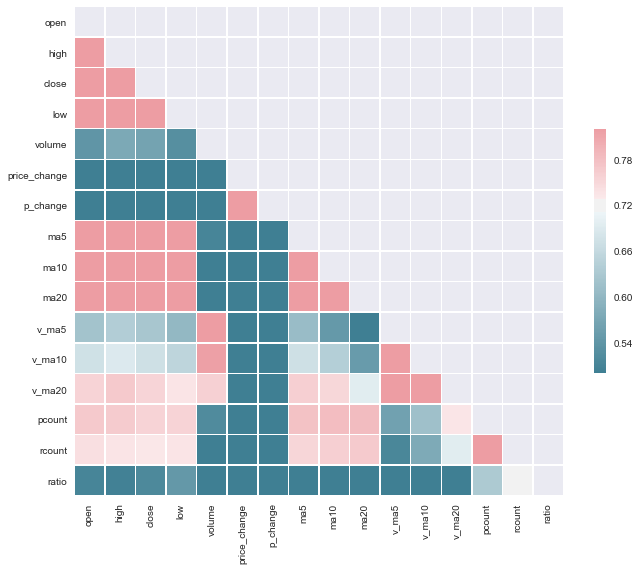

In [16]:
sns.set(style="darkgrid")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=.5, vmax=.82, center=.72,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

> 红色越深表示相关系数越接近1

同样地，算一下P值，看看显著性，这里以20日均价和发帖量为例

In [17]:
r, p = stats.spearmanr(ndf['ma20'], ndf['pcount'])
r, p

(0.78453685256941941, 4.6579624282353562e-60)

数据好到反正我是不信的，最后再用`seaborn`里的散点图看一下

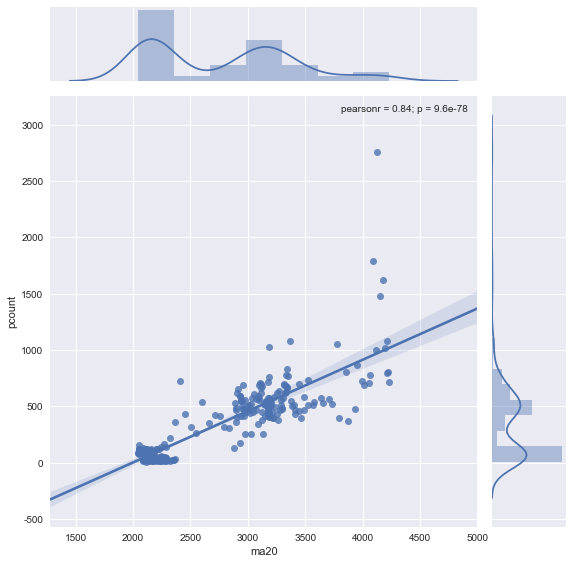

In [18]:
sns.jointplot('ma20', 'pcount', data=ndf, kind="reg", size=8)
plt.show()

> 很明显，在ma20接近2000的地方，发帖量也接近于0，且数据量非常大，发帖量小的原因应该是在论坛建立之初，人气比较低所致。可是却暗合了指数在2000多点徘徊许久的事实。
> 虽然直觉上觉得数据的分布对相关分析产生了影响，但是受限于我的数学知识，无力。。。。